# Producing sounds for pictures with Convolutional Neural Network

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Input, Conv2D, MaxPooling2D, Dropout
from keras import regularizers
from keras import optimizers
from keras.datasets import cifar10
from keras.utils import np_utils

import math
import numpy as np
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from pydub import AudioSegment
from pydub.playback import play

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# normalization
mean = np.mean(X_train, axis=(0,1,2))
X_train_mean = X_train - mean
X_test_mean = X_test - mean
X_train_meanstd = X_train_mean/np.std(X_train, axis=(0,1,2))
X_test_meanstd = X_test_mean/np.std(X_train, axis=(0,1,2))

X_train_in = X_train_meanstd
X_test_in = X_test_meanstd

num_classes = 10
y_train_in = np_utils.to_categorical(y_train,num_classes)
y_test_in = np_utils.to_categorical(y_test,num_classes)

print('-----')
print('Train_in data shape: ', X_train_in.shape)
print('Train_in labels shape: ', y_train_in.shape)
print('Test_in data shape: ', X_test_in.shape)
print('Test_in labels shape: ', y_test_in.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)
-----
Train_in data shape:  (50000, 32, 32, 3)
Train_in labels shape:  (50000, 10)
Test_in data shape:  (10000, 32, 32, 3)
Test_in labels shape:  (10000, 10)


## Network

In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

weight_decay = 1e-4

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train_in.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

opt_rms = optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2

## Load weights file of the best model

In [5]:
weights_file = 'weights/w_1/Weights-053--0.54426.hdf5' # put the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

## Plotting

In [6]:
plt.rcParams["figure.figsize"] = (3,3)
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Playing

In [7]:
def play_file(name):
    play_mixed([name], [1])
    
def play_mixed(names, volumes):
    name_prefix = 'data/sounds/'
    name_postfix = '_10_calibrated.mp3'
    sounds = []
    volume_range = 100
    output = None
    
    for i in range(len(names)):
        name = names[i]
        sound = AudioSegment.from_mp3(name_prefix + name + name_postfix)
        sound -= volume_range * (1 - volumes[i])
        sounds.append(sound)
        if output == None:
            output = sound
        else:
            output = output.overlay(sound)

    output.export('last_experiment.mp3', format='mp3')
    play(output)

## Building

In [8]:
labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

sound_files = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'big_enough', # deer - it's pretty much it
    'dog',
    'frog',
    'horse',
    'ship',
    'skyrim' # truck - too similar to ship
]

def normilize_predictions(predicted_labels):
    return (predicted_labels - min(predicted_labels)) / (max(predicted_labels)- min(predicted_labels))

### Basic

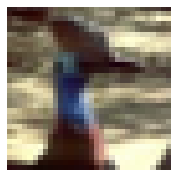

bird


In [19]:
idx = randint(0, X_test.shape[0])
predicted_labels = model.predict(X_test_in[idx:idx + 1])[0]
predicted_norm = normilize_predictions(predicted_labels)

plot_image(X_test[idx])
print(labels[y_test[idx][0]])
play_mixed(sound_files, predicted_norm)

### Mixed

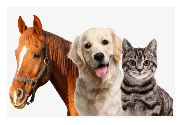

min size
108.8 108.8
current size
544 544
current size
272 272
current size
136 136
samples
31


In [20]:
def build_images(image_path):
    images = []
    weights = []
    
    image = Image.open(image_path)
    np_array = np.asarray(image)
    plot_image(np_array)
    width, height = image.size
    
    # network input size
    base_width = 32
    base_height = 32
    
    current_x = 0
    current_y = 0
    current_width = min(width, height)
    current_height = min(width, height)
    current_step = current_width // base_width
    min_width = current_width / 5
    min_height = current_height / 5
    print('min size')
    print(min_width, min_height)
    
    while current_width >= min_width and current_height >= min_height:
        print('current size')
        print(current_width, current_height)
        while current_x + current_width <= width and current_y + current_height <= height:
            processed_image = image.crop((current_x,
                                          current_y,
                                          current_x + current_width,
                                          current_y + current_height))
            processed_image = processed_image.resize((base_width, base_height), Image.ANTIALIAS)
            
            # weights are proportional to cutted portion
            weights.append(current_width / width)

            np_array = np.asarray(processed_image)
            images.append(np_array)
            #plot_image(np_array)
            
            current_x += current_width
            # current_x += current_step
            if current_x + current_width > width:
                current_x = 0
                # current_y += current_step
                current_y += current_height
                
        current_x = 0
        current_y = 0
        current_width //= 2
        current_height = current_width
        current_step //= 2
        
    result = np.asarray(images)
    print('samples')
    print(len(result))
    return result, weights

image_path = 'data/singles/horse_dog_cat.jpg'
images, weights = build_images(image_path)
predicted_array = model.predict(images)
predicted_labels = np.zeros(num_classes)
for i in range(len(weights)):
    predictions = predicted_array[i]
    predicted_labels += predictions * weights[i]

predicted_norm = normilize_predictions(predicted_labels)
play_mixed(sound_files, predicted_norm)